In [1]:
from PIL import Image, ImageFont, ImageDraw, ImageOps
import numpy as np
from matplotlib import pyplot as plt
import csv
from operator import itemgetter

# бинаризуем изображение
def simple_binarization(image, threshold):
  img_arr = np.array(image)
  new_image = np.zeros(shape=img_arr.shape)
  new_image[img_arr > threshold] = 255
  return Image.fromarray(new_image.astype(np.uint8), 'L')

In [11]:
# вырезаем белые места из изображения буквы
def cut_empty_rows_and_cols(image):

    empty_row_numbers = []
    empty_column_numbers = []

    for x in range(image.width): #ищем пустые строки и столбцы 
        is_col_empty = True
        for y in range(image.height):
            if image.getpixel((x, y)) < 255:
                is_col_empty = False
                break

        if is_col_empty:
            empty_column_numbers.append(x)

    for y in range(image.height):
        is_row_empty = True
        for x in range(image.width):
            if image.getpixel((x, y)) < 255:
                is_row_empty = False
                break

        if is_row_empty:
            empty_row_numbers.append(y)

    def last_element_in_a_row(elements, start_element, step):  #определяем края обрезки
        prev_element = start_element

        for element in elements[::step]:
            if abs(element - prev_element) > 1:
                return prev_element + step

            prev_element = element

        return prev_element + step

    left_whitespace_end = last_element_in_a_row(empty_column_numbers, -1, 1)
    upper_whitespace_end = last_element_in_a_row(empty_row_numbers, -1, 1)
    right_whitespace_end = last_element_in_a_row(empty_column_numbers, image.width, -1)
    lower_whitespace_end = last_element_in_a_row(empty_row_numbers, image.height, -1)

    return image.crop(box=(left_whitespace_end, upper_whitespace_end, right_whitespace_end + 1, lower_whitespace_end + 1)) #обрезаем пустоту, оставляя просто прямоугольник


In [12]:
def generate_sentence(font_size, txt = '𐎎𐎏𐎐 𐎀𐎁𐎜𐎝'):
  font = ImageFont.truetype("../5sem/results/output/fonts/NotoSansUgaritic-Regular.ttf", font_size)
  img = Image.new(mode="L", size=(2555, font_size), color=255)
  draw = ImageDraw.Draw(img, mode = 'L')
  draw.text(xy=(0, 0), text= txt, fill=0, font=font, anchor = 'lt')
  cutted_img = cut_empty_rows_and_cols(img) # cut_white_image_parts(img)
  result_img = simple_binarization(cutted_img, 100)
  result_img.save(f'../7sem/results/output/font_{font_size}_test.png')
  return result_img 

In [13]:
# получаем значения характеристик
def get_features(img):
  img_pixels = img.load()
  
  width = img.size[0]
  height = img.size[1]

  size = width * height

  weight, rel_weight, x_avg, y_avg, rel_x_avg, rel_y_avg = 0, 0, 0, 0, 0, 0
  inertia_x, rel_inertia_x, inertia_y, rel_inertia_y = 0, 0, 0, 0

  for i in range(width):
    for j in range(height):
      if img_pixels[i, j] == 0:  #если черный, то увеличиваем вес
        weight += 1
        x_avg += i
        y_avg += j

  rel_weight = weight / size

  x_avg /= weight
  y_avg /= weight
  rel_x_avg = (x_avg - 1) / (width - 1)
  rel_y_avg = (y_avg - 1) / (height - 1)

  for i in range(width):
    for j in range(height):
      if img_pixels[i, j] == 0:
        inertia_x = (j - x_avg) ** 2
        inertia_y = (i - y_avg) ** 2

  rel_inertia_x = inertia_x / (width ** 2 + height ** 2)
  rel_inertia_y = inertia_y / (width ** 2 + height ** 2)
  
  # 'rel_weight' 'rel_x_avg' 'rel_y_avg' 'rel_inertia_x' 'rel_inertia_y'
  return (rel_weight, rel_x_avg, rel_y_avg, rel_inertia_x, rel_inertia_y)

def color_used_arr(img):
  return np.asarray(np.asarray(img) < 1, dtype = np.int0)


In [16]:
# сегментируем фразу на отдельные буквы
def get_segments_list(img):
  img_arr_for_calculations = color_used_arr(img)
  x_profiles = np.sum(img_arr_for_calculations, axis=0)
  x_profiles[0] = 0
  lst = []  #индексы где нет черных пикселей
  new_lst = []  #начало и конец сегментов
  for i in range(len(x_profiles)): #заполняем где нет черных 
    if x_profiles[i] == 0:
      lst.append(i)
  lst.append(img.width)  #добавляем ширину изображения в конец списка для обозначения конца последнего сегмента
#пары индексов, обозначающих начало и конец
  for i in range(len(lst)-1):
    if lst[i] + 1 != lst[i+1]:
      new_lst.append(lst[i])
      new_lst.append(lst[i+1])
  new_lst.append(img.width-1)
  new_lst = sorted(list(set(new_lst))) #убирем дубликаты и отсортируем список
  
  segments = []
  for i in range(0, len(new_lst)-1, 2):
    segments.append((new_lst[i], new_lst[i+1]))
  return segments

In [15]:
def get_letter_images(image):  #функция обрезки для получения отдельного изображения букв
  letter_images_list = []
  
  segments = get_segments_list(image)
  
  for segment in segments:
    letter_image = image.crop(box=(segment[0], 0, segment[1]+1, image.height))
    cutted_letter_image = cut_empty_rows_and_cols(letter_image)
    
    letter_images_list.append(cutted_letter_image)
  return letter_images_list

def get_probability_list(img, reference_letter_list, reference_letter_features_list):
  letter_images_list = get_letter_images(img)
  full_list = []

  for i, letter in enumerate(letter_images_list):
    # получаем профиль данной буквы
    recognized_letter_features = get_features(letter)
    euclid_distances = []  #список для хранения Евклидовых расстояний между характеристиками текущей буквы и каждой эталонной буквой

    for ind, ref_letter in enumerate(reference_letter_list):
      zipped_features = zip(recognized_letter_features, reference_letter_features_list[ind])
      euclid_distance = 0

      # считаем дистанцию
      for el in zipped_features:
        euclid_distance += (el[0] - el[1]) ** 2 #для каждой пары признаков вычисляется квадрат разности и добавляется к общей сумме
      euclid_distance = euclid_distance ** 0.5
      euclid_distances.append([ref_letter, euclid_distance])

    # сортируем и находим ближайшее подходящее
    euclid_distances = sorted(euclid_distances, key = itemgetter(1)) #по возрастанию
    max_dist = max(euclid_distances, key = itemgetter(1))[1]

    for n in range(len(euclid_distances)):  #мера сходства (чем меньше расстояние, тем выше сходство)
      euclid_distances[n][1] /= max_dist
      euclid_distances[n][1] = round(1 - euclid_distances[n][1], 2)
      euclid_distances[n] = tuple(euclid_distances[n])

    full_list.append((i + 1, euclid_distances))
    print(euclid_distances[:5])
  return full_list

# Метрики

In [19]:
# получаем профили из 5 лабы
with open('../5sem/results/ugarian_font.csv', 'r', encoding='utf-8') as f:
  reader = csv.DictReader(f, fieldnames=['letter', 'weight', 'rel_weight',
                                        'x_avg', 'y_avg', 'rel_x_avg', 'rel_y_avg', 
                                        'inertia_x', 'inertia_y', 'rel_inertia_x', 'rel_inertia_y'])
  next(reader)
  reference_letter_list = []
  reference_letter_features_list = []
  for row in reader:
    reference_letter_list.append(row['letter'])
    reference_letter_features_list.append((float(row['rel_weight']), float(row['rel_x_avg']), float(row['rel_y_avg']), 
                                          float(row['rel_inertia_x']), float(row['rel_inertia_y'])))
    
test = '𐎌𐎍𐎎𐎏 𐎁𐎂𐎃𐎄 𐎙𐎚𐎛𐎜𐎝 𐎉𐎊'
# генерируем текст 120 шрифтом
phrase_some_size = generate_sentence(120, test)

# пытаемся распознать
euclid_distances_some_size = get_probability_list(phrase_some_size, reference_letter_list, reference_letter_features_list)

recognized_text = ''
for el in euclid_distances_some_size:
  recognized_text += el[1][0][0]

index = 0
count = 0
for let in recognized_text:
  print(let, test[index])
  if(let == test[index]):
    count += 1
  index += 1

print('Metric: ', count / index * 100)

[('𐎓', 0.98), ('𐎘', 0.75), ('𐎝', 0.71), ('𐎃', 0.64), ('𐎊', 0.54)]
[('𐎒', 0.87), ('𐎕', 0.86), ('𐎂', 0.85), ('𐎛', 0.78), ('𐎍', 0.75)]
[('𐎂', 0.97), ('𐎕', 0.9), ('𐎒', 0.87), ('𐎇', 0.85), ('𐎊', 0.8)]
[('𐎂', 0.96), ('𐎕', 0.88), ('𐎇', 0.87), ('𐎒', 0.84), ('𐎊', 0.8)]
[('𐎂', 0.95), ('𐎕', 0.88), ('𐎇', 0.86), ('𐎒', 0.84), ('𐎊', 0.8)]
[('𐎎', 0.97), ('𐎍', 0.75), ('𐎌', 0.74), ('𐎉', 0.72), ('𐎈', 0.71)]
[('𐎏', 0.97), ('𐎈', 0.91), ('𐎉', 0.85), ('𐎌', 0.83), ('𐎖', 0.81)]
[('𐎁', 0.94), ('𐎅', 0.84), ('𐎜', 0.77), ('𐎄', 0.74), ('𐎛', 0.69)]
[('𐎂', 0.97), ('𐎕', 0.9), ('𐎒', 0.87), ('𐎇', 0.85), ('𐎊', 0.8)]
[('𐎃', 0.93), ('𐎊', 0.76), ('𐎝', 0.73), ('𐎘', 0.73), ('𐎇', 0.69)]
[('𐎑', 0.92), ('𐎗', 0.9), ('𐎆', 0.88), ('𐎋', 0.88), ('𐎔', 0.88)]
[('𐎙', 0.95), ('𐎆', 0.84), ('𐎋', 0.83), ('𐎔', 0.77), ('𐎑', 0.77)]
[('𐎚', 0.95), ('𐎀', 0.87), ('𐎐', 0.82), ('𐎗', 0.64), ('𐎑', 0.63)]
[('𐎛', 0.94), ('𐎅', 0.86), ('𐎁', 0.83), ('𐎏', 0.74), ('𐎈', 0.71)]
[('𐎜', 0.97), ('𐎄', 0.92), ('𐎗', 0.74), ('𐎑', 0.72), ('𐎁', 0.71)]
[('𐎓', 0.66), ('𐎘

C:\Users\Kokovino\AppData\Local\Temp\ipykernel_13636\4244578446.py:40: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  return np.asarray(np.asarray(img) < 1, dtype = np.int0)


IndexError: string index out of range

In [20]:
# получаем профили из 5 лабы
with open('../5sem/results/ugarian_font.csv', 'r', encoding='utf-8') as f:
  reader = csv.DictReader(f, fieldnames=['letter', 'weight', 'rel_weight',
                                        'x_avg', 'y_avg', 'rel_x_avg', 'rel_y_avg', 
                                        'inertia_x', 'inertia_y', 'rel_inertia_x', 'rel_inertia_y'])
  next(reader)
  reference_letter_list = []
  reference_letter_features_list = []
  for row in reader:
    reference_letter_list.append(row['letter'])
    reference_letter_features_list.append((float(row['rel_weight']), float(row['rel_x_avg']), float(row['rel_y_avg']), 
                                          float(row['rel_inertia_x']), float(row['rel_inertia_y'])))
    

# генерируем текст 120 шрифтом
phrase_some_size = generate_sentence(120, '𐎙𐎚𐎛𐎜𐎝 𐎉𐎊')

# пытаемся распознать
euclid_distances_some_size = get_probability_list(phrase_some_size, reference_letter_list, reference_letter_features_list)

recognized_text = ''
for el in euclid_distances_some_size:
  recognized_text += el[1][0][0]
print(recognized_text)

with open('recognize_result.txt', 'w', encoding='utf-8') as f:
  for row in euclid_distances_some_size:
    f.write(f"{row}\n")

[('𐎙', 0.95), ('𐎆', 0.84), ('𐎋', 0.83), ('𐎔', 0.77), ('𐎑', 0.77)]
[('𐎚', 0.95), ('𐎀', 0.87), ('𐎐', 0.82), ('𐎗', 0.64), ('𐎑', 0.63)]
[('𐎛', 0.94), ('𐎅', 0.86), ('𐎁', 0.83), ('𐎏', 0.74), ('𐎈', 0.71)]
[('𐎜', 0.97), ('𐎄', 0.92), ('𐎗', 0.74), ('𐎑', 0.72), ('𐎁', 0.71)]
[('𐎓', 0.66), ('𐎘', 0.5), ('𐎃', 0.48), ('𐎝', 0.47), ('𐎊', 0.33)]
[('𐎂', 0.97), ('𐎕', 0.9), ('𐎒', 0.87), ('𐎇', 0.85), ('𐎊', 0.8)]
[('𐎓', 0.66), ('𐎘', 0.5), ('𐎃', 0.48), ('𐎝', 0.47), ('𐎊', 0.33)]
[('𐎉', 0.97), ('𐎌', 0.92), ('𐎈', 0.9), ('𐎖', 0.8), ('𐎏', 0.78)]
[('𐎃', 0.93), ('𐎊', 0.76), ('𐎝', 0.73), ('𐎘', 0.73), ('𐎇', 0.69)]
[('𐎃', 0.95), ('𐎊', 0.76), ('𐎝', 0.72), ('𐎘', 0.72), ('𐎇', 0.7)]
𐎙𐎚𐎛𐎜𐎓𐎂𐎓𐎉𐎃𐎃


C:\Users\Kokovino\AppData\Local\Temp\ipykernel_13636\4244578446.py:40: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  return np.asarray(np.asarray(img) < 1, dtype = np.int0)


# Тесты различных размеров


In [28]:
# получаем профили из 5 лабы
with open('../5sem/results/ugarian_font.csv', 'r', encoding='utf-8') as f:
  reader = csv.DictReader(f, fieldnames=['letter', 'weight', 'rel_weight',
                                        'x_avg', 'y_avg', 'rel_x_avg', 'rel_y_avg', 
                                        'inertia_x', 'inertia_y', 'rel_inertia_x', 'rel_inertia_y'])
  next(reader)
  reference_letter_list = []
  reference_letter_features_list = []
  for row in reader:
    reference_letter_list.append(row['letter'])
    reference_letter_features_list.append((float(row['rel_weight']), float(row['rel_x_avg']), float(row['rel_y_avg']), 
                                          float(row['rel_inertia_x']), float(row['rel_inertia_y'])))

In [29]:
phrase_100 = generate_sentence(100)

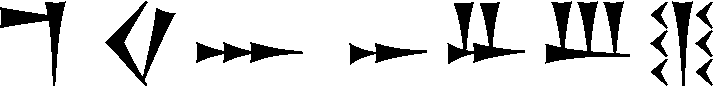

In [30]:
phrase_100

In [32]:
euclid_distances_100 = get_probability_list(phrase_100, reference_letter_list, reference_letter_features_list)

[('𐎎', 0.99), ('𐎍', 0.75), ('𐎌', 0.74), ('𐎉', 0.72), ('𐎈', 0.71)]
[('𐎏', 0.98), ('𐎈', 0.9), ('𐎉', 0.84), ('𐎌', 0.82), ('𐎖', 0.81)]
[('𐎐', 0.91), ('𐎀', 0.81), ('𐎚', 0.8), ('𐎗', 0.57), ('𐎑', 0.55)]
[('𐎀', 0.92), ('𐎐', 0.88), ('𐎚', 0.85), ('𐎗', 0.63), ('𐎑', 0.62)]
[('𐎁', 0.94), ('𐎅', 0.84), ('𐎜', 0.77), ('𐎄', 0.74), ('𐎛', 0.69)]
[('𐎜', 1.0), ('𐎄', 0.9), ('𐎁', 0.73), ('𐎗', 0.71), ('𐎑', 0.7)]
[('𐎓', 0.67), ('𐎘', 0.51), ('𐎃', 0.49), ('𐎝', 0.48), ('𐎊', 0.34)]
[('𐎂', 0.97), ('𐎕', 0.89), ('𐎇', 0.86), ('𐎒', 0.85), ('𐎊', 0.8)]
[('𐎓', 0.67), ('𐎘', 0.51), ('𐎃', 0.49), ('𐎝', 0.48), ('𐎊', 0.34)]


C:\Users\Kokovino\AppData\Local\Temp\ipykernel_13636\4244578446.py:40: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  return np.asarray(np.asarray(img) < 1, dtype = np.int0)


In [33]:
recognized_text = ''
for el in euclid_distances_100:
    recognized_text += el[1][0][0]
recognized_text

'𐎎𐎏𐎐𐎀𐎁𐎜𐎓𐎂𐎓'

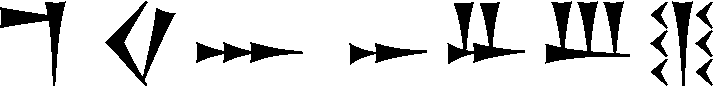

In [34]:
phrase_100

In [35]:
with open('../7sem/results/output/result_100.txt', 'w', encoding='utf-8') as f:
    for row in euclid_distances_100:
        f.write(f"{row}\n")

In [36]:
phrase_48 = generate_sentence(48)

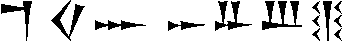

In [37]:
phrase_48

In [38]:
euclid_distances_48 = get_probability_list(phrase_48, reference_letter_list, reference_letter_features_list)

[('𐎎', 0.94), ('𐎍', 0.75), ('𐎌', 0.73), ('𐎉', 0.69), ('𐎒', 0.69)]
[('𐎏', 0.97), ('𐎈', 0.88), ('𐎉', 0.82), ('𐎌', 0.81), ('𐎒', 0.81)]
[('𐎐', 0.89), ('𐎀', 0.83), ('𐎚', 0.8), ('𐎗', 0.57), ('𐎑', 0.56)]
[('𐎀', 0.85), ('𐎐', 0.81), ('𐎚', 0.77), ('𐎗', 0.59), ('𐎋', 0.57)]
[('𐎁', 0.95), ('𐎅', 0.86), ('𐎛', 0.75), ('𐎜', 0.75), ('𐎄', 0.7)]
[('𐎜', 0.94), ('𐎄', 0.88), ('𐎗', 0.73), ('𐎁', 0.71), ('𐎑', 0.7)]
[('𐎓', 0.64), ('𐎘', 0.47), ('𐎃', 0.47), ('𐎝', 0.44), ('𐎊', 0.31)]
[('𐎇', 0.86), ('𐎂', 0.85), ('𐎕', 0.79), ('𐎒', 0.75), ('𐎊', 0.74)]
[('𐎓', 0.62), ('𐎃', 0.46), ('𐎘', 0.46), ('𐎝', 0.43), ('𐎅', 0.3)]


C:\Users\Kokovino\AppData\Local\Temp\ipykernel_13636\4244578446.py:40: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  return np.asarray(np.asarray(img) < 1, dtype = np.int0)


In [39]:
recognized_text_48 = ''
for el in euclid_distances_48:
    recognized_text_48 += el[1][0][0]
recognized_text_48

'𐎎𐎏𐎐𐎀𐎁𐎜𐎓𐎇𐎓'

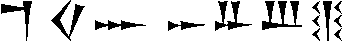

In [40]:
phrase_48

In [41]:
with open('../7sem/results/output/result_48.txt', 'w', encoding='utf-8') as f:
    for row in euclid_distances_48:
        f.write(f"{row}\n")